In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [3]:
df_dev = load_dataset("csv", data_files="subtaskB_clean_dev_cased.csv")#, column_names=['text', 'label'])#, features=features)
df_test = load_dataset("csv", data_files="subtaskB_clean_test_cased.csv")#, column_names=['text', 'label'])#, features=features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
df_dev = df_dev.rename_column("comment_text", "text")
df_dev = df_dev.rename_column("topic", "label")
df_test = df_test.rename_column("comment_text", "text")

In [5]:
class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

In [6]:
label = ClassLabel(num_classes=4, names=class_names)
#features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=4, names=class_names)})

In [7]:
df_dev = df_dev.cast_column("label", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [8]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 810
    })
})

In [9]:
np.unique(df_dev['train']['label'], return_counts=True)

(array([0, 1, 2, 3]), array([435, 242,  57,  76]))

# Data partioning

In [10]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 243
    })
})

In [11]:
df_train = train_val["train"]
df_val = train_val["test"]

In [12]:
df_val

Dataset({
    features: ['text', 'label'],
    num_rows: 243
})

In [13]:
np.unique(df_val['label'], return_counts=True)

(array([0, 1, 2, 3]), array([130,  73,  17,  23]))

# Model loading

In [15]:
nome = 'distilbert_base'
model_name = 'distilbert-base-multilingual-cased'

In [16]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [17]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [18]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [19]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 567
})

In [20]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [21]:
label2id = {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
}

In [30]:
def hyperparameter_search(model_name=model_name, optim='adamw_hf', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=15,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )

    config = AutoConfig.from_pretrained(model_name, num_labels=4)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)#, num_labels=4)
    config.label2id = label2id
    return training_args, model

Provare:

Optimizer: SGD, Adagrad,

Learning rate: 0.00005, ...

Dropout: 0.1, ...

In [31]:
training_args, model = hyperparameter_search()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

In [25]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [33]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.900500,0.599666,0.773586
2,0.469900,0.593390,0.742706
3,0.232000,0.729759,0.795369
4,0.126900,0.877605,0.804913
5,0.074600,1.086085,0.755496
6,0.037500,1.090280,0.800909
7,0.019100,1.194142,0.770688
8,0.023200,1.248163,0.778529
9,0.009300,1.156515,0.778230
10,0.000900,1.286514,0.779499


CPU times: user 8min 46s, sys: 31.8 s, total: 9min 18s
Wall time: 11min 29s


TrainOutput(global_step=1065, training_loss=0.1264827233769804, metrics={'train_runtime': 688.7848, 'train_samples_per_second': 12.348, 'train_steps_per_second': 1.546, 'total_flos': 1126675409448960.0, 'train_loss': 0.1264827233769804, 'epoch': 15.0})

# Evaluation

In [34]:
log_history = trainer.state.log_history

In [35]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)

<ipython-input-35-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-35-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-35-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-35-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [36]:
from IPython.display import HTML

df.to_html(f'loss_{nome}.html')

display(HTML(f'loss_{nome}.html'))

,Epoch,Loss,Dataset
0,1,0.900500,Training
1,1,0.599666,Validation
2,2,0.469900,Training
3,2,0.593390,Validation
4,3,0.232000,Training
5,3,0.729759,Validation
6,4,0.126900,Training
7,4,0.877605,Validation
8,5,0.074600,Training
9,5,1.086085,Validation


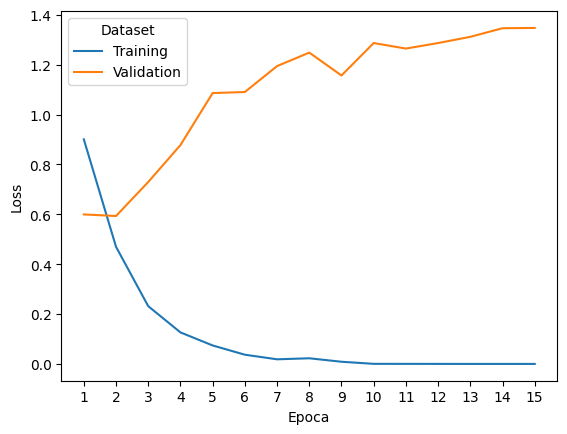

In [37]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
output_predictions = trainer.predict(tokenized_val)

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
y_val = tokenized_val["label"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       130
           1       0.71      0.75      0.73        73
           2       0.81      0.76      0.79        17
           3       0.95      0.78      0.86        23

    accuracy                           0.81       243
   macro avg       0.83      0.79      0.80       243
weighted avg       0.81      0.81      0.81       243



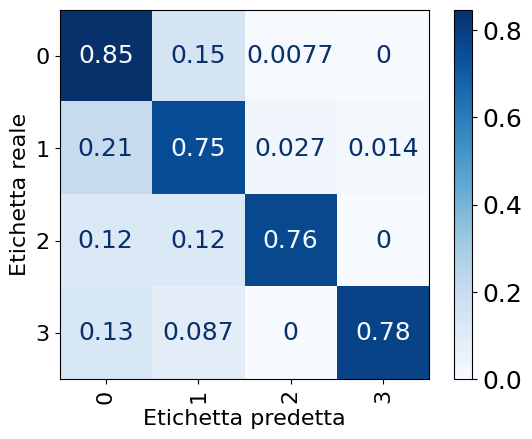

In [42]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{model_name}.pdf', dpi=300, bbox_inches='tight')
plt.show()